## Лабораторная работа № 1 
## Выполнение разведочного анализа больших данных с использованием фреймворка Apache Spark

### Часть 2

В данной части работы рассмотрены:
* разведочный анализ данных;
* работа с Dataframe API фреймворка `Apache Spark`.

Подключаем необходимые библиотеки.

In [82]:
import os
from pyspark.sql import SparkSession, DataFrame
from pyspark import SparkConf
from pyspark.sql.functions import (
    col, lit, sum, mean, when,
    explode, count, desc, floor,
    corr, array_contains, lit, first
)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Сформируем объект конфигурации для `Apache Spark`, указав необходимые параметры.

In [83]:
def create_spark_configuration() -> SparkConf:
    """
    Создает и конфигурирует экземпляр SparkConf для приложения Spark.

    Returns:
        SparkConf: Настроенный экземпляр SparkConf.
    """
    # Получаем имя пользователя
    user_name = os.getenv("USER")
    
    conf = SparkConf()
    conf.setAppName("lab 1 Test")
    conf.setMaster("yarn")
    conf.set("spark.submit.deployMode", "client")
    conf.set("spark.executor.memory", "12g")
    conf.set("spark.executor.cores", "8")
    conf.set("spark.executor.instances", "2")
    conf.set("spark.driver.memory", "4g")
    conf.set("spark.driver.cores", "2")
    conf.set("spark.jars.packages", "org.apache.iceberg:iceberg-spark-runtime-3.5_2.12:1.6.0")
    conf.set("spark.sql.extensions", "org.apache.iceberg.spark.extensions.IcebergSparkSessionExtensions")
    conf.set("spark.sql.catalog.spark_catalog", "org.apache.iceberg.spark.SparkCatalog")
    conf.set("spark.sql.catalog.spark_catalog.type", "hadoop")
    conf.set("spark.sql.catalog.spark_catalog.warehouse", f"hdfs:///user/{user_name}/warehouse")
    conf.set("spark.sql.catalog.spark_catalog.io-impl", "org.apache.iceberg.hadoop.HadoopFileIO")

    return conf

Создаём сам объект конфигурации.

In [84]:
conf = create_spark_configuration()

Создаём и выводим на экран сессию `Apache Spark`. В процессе создания сессии происходит подключение к кластеру `Apache Hadoop`, что может занять некоторое время.

In [85]:
spark = SparkSession.builder.config(conf=conf).getOrCreate()
spark

24/10/22 17:29:17 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


Укажем базу данных, которая была создана в первой части лабораторной работы.

In [86]:
database_name = "andreev_database_new"

Установим созданную базу данных как текущую.

In [87]:
spark.catalog.setCurrentDatabase(database_name)

Прочитаем сохранённую в предыдущей части работы таблицу и загрузим её в `Spark Dataframe`.

In [88]:
df = spark.table("sobd_lab1_table")

Выведем прочитанную таблицу на экран.

In [89]:
df.show()

+--------------------+---------------+------------------+------------+--------+---------+---------------------------------+--------------------+----------------------------+-------------------------+----------------+-------------------+
|               legId|startingAirport|destinationAirport|isRefundable|baseFare|totalFare|segmentsDepartureTimeEpochSeconds| segmentsAirlineName|segmentsEquipmentDescription|segmentsDurationInSeconds|segmentsDistance|  segmentsCabinCode|
+--------------------+---------------+------------------+------------+--------+---------+---------------------------------+--------------------+----------------------------+-------------------------+----------------+-------------------+
|299f9d6c22aa24bc9...|            PHL|               MIA|       false|  161.86|    197.6|                             NULL|American Airlines...|        Canadian Regional...|               9540||4740|        747||330|       coach||coach|
|5371f89133a4357ea...|            PHL|              

Посмотрим на схему данных.

In [90]:
df.printSchema()

root
 |-- legId: string (nullable = true)
 |-- startingAirport: string (nullable = true)
 |-- destinationAirport: string (nullable = true)
 |-- isRefundable: boolean (nullable = true)
 |-- baseFare: float (nullable = true)
 |-- totalFare: float (nullable = true)
 |-- segmentsDepartureTimeEpochSeconds: integer (nullable = true)
 |-- segmentsAirlineName: string (nullable = true)
 |-- segmentsEquipmentDescription: string (nullable = true)
 |-- segmentsDurationInSeconds: string (nullable = true)
 |-- segmentsDistance: string (nullable = true)
 |-- segmentsCabinCode: string (nullable = true)



Вычислим количество строк в датафрейме.

In [91]:
df.count()

82138753

#### Анализ столбца `legId `

Отсортируем датафрейм по столбцу `legId`, который может рассматриваться в качестве первичного ключа таблицы.

In [92]:
df.orderBy("legId", ascending=False).show()

+--------------------+---------------+------------------+------------+--------+---------+---------------------------------+-------------------+----------------------------+-------------------------+----------------+-----------------+
|               legId|startingAirport|destinationAirport|isRefundable|baseFare|totalFare|segmentsDepartureTimeEpochSeconds|segmentsAirlineName|segmentsEquipmentDescription|segmentsDurationInSeconds|segmentsDistance|segmentsCabinCode|
+--------------------+---------------+------------------+------------+--------+---------+---------------------------------+-------------------+----------------------------+-------------------------+----------------+-----------------+
|ffffffc70e6f33139...|            SFO|               EWR|       false|  347.91|    397.6|                             NULL|       Delta||Delta|        Boeing 737-900||B...|              16200||6600|       2083||485|     coach||coach|
|ffffffc70e6f33139...|            SFO|               EWR|       

Проверим dataframe на наличие пустых данных в столбце `legId`

In [93]:
empty_airline_names = df.filter(col("legId").isNull() | (col("legId") == "")).count()

print(empty_airline_names)

0


Проверим наличие дубликатов в датафрейме.

In [94]:
(
    df
    .groupBy("legId")
    .count()
    .where("count > 1")
    .orderBy("count", ascending=False)
    .show(truncate=False)
)

+--------------------------------+-----+
|legId                           |count|
+--------------------------------+-----+
|acba22c02469274e43928521bcead4c8|61   |
|6365830250822d8732e98ac28735f7b0|61   |
|65f59b3c81d5fcdea844c33e88cb2348|61   |
|b2feca28d8d28bff3fe8b9aae6cc9832|61   |
|809668b03345672b1487b8582c0b3fd2|61   |
|f6a29d9fb31867ca4b2fc02d2ed1e713|61   |
|318ae5fe46ac6a4ed5e1ee55f5b53677|61   |
|fea1345623050a76e9f38ec4e5f924f2|61   |
|8e47f9c2a40d3a9c6cf652ead5acbe3d|60   |
|b3abf3ac8fadb7c8a0657165184faf24|60   |
|d45f9f7dd50b94eda0a2d41f842d97bf|60   |
|01847203d05b75b26dd533e802b5ff61|60   |
|14ee5ea695c87156e8a0c926b82bbc9e|60   |
|ad78c7cdc78b7064b14ba5291a25cf11|60   |
|10d37dc5bc19f7e7724a26ed5fd99275|60   |
|a834beb72accdbaaf6515cb9fc6aa06a|60   |
|bc6007d7540f4bc0e5a4a991892c2a6b|60   |
|ce8aa10ab37cfb9a4327470a87d7e64d|60   |
|65ca4bdbddc24959fa17c8d89a70849b|60   |
|3316c444adbfb81d4cef3fec9f928ae5|60   |
+--------------------------------+-----+
only showing top

Дубликаты есть. Посмотрим, что они собой представляют (на примере одной записи).

In [95]:
df.filter(col("legId") == "809668b03345672b1487b8582c0b3fd2").show(truncate=False)

+--------------------------------+---------------+------------------+------------+--------+---------+---------------------------------+--------------------------------+---------------------------------+-------------------------+----------------+-----------------+
|legId                           |startingAirport|destinationAirport|isRefundable|baseFare|totalFare|segmentsDepartureTimeEpochSeconds|segmentsAirlineName             |segmentsEquipmentDescription     |segmentsDurationInSeconds|segmentsDistance|segmentsCabinCode|
+--------------------------------+---------------+------------------+------------+--------+---------+---------------------------------+--------------------------------+---------------------------------+-------------------------+----------------+-----------------+
|809668b03345672b1487b8582c0b3fd2|ORD            |LAX               |false       |112.0   |219.58   |NULL                             |Spirit Airlines||Spirit Airlines|AIRBUS INDUSTRIE A321 SHARKLETS|||11460|

Здесь наблюдается идентичность строк, однако столбцы `baseFare` и `totalFare` разные. Это может говорить о том, что могут быть разные предложения для того же рейса в зависимости от времени бронирования.

In [96]:
df = df.dropDuplicates(["legId"])
df.count()

5999739

#### Анализ столбца `startingAirport`



Определим количество пустых значений

In [97]:
def count_nulls(data: DataFrame,
                column_name: str) -> None:
    """
    Подсчет количества null и not null значений в указанном столбце.

    Args:
        data (DataFrame): DataFrame, содержащий данные.
        column_name (str): Имя столбца для подсчета null и not null значений.
    
    Returns:
        None
    """
    # Подсчет количества null значений в указанном столбце
    null_counts = data.select(
        sum(col(column_name).isNull().cast("int"))
    ).collect()[0][0]

    # Подсчет количества not null значений в указанном столбце
    not_null_counts = data.select(
        sum(col(column_name).isNotNull().cast("int"))
    ).collect()[0][0]

    # Вывод результатов
    print(f"Число колонок с NULL: {null_counts} "
          f"({100 * null_counts / (null_counts + not_null_counts):.2f}%)")

In [98]:
count_nulls(data=df, column_name="startingAirport")

Число колонок с NULL: 0 (0.00%)


Поскольку пустых значений нету, то сразу перейдем к созданию функции расчета и визуализации распределения категориальных признаков.

In [99]:
def plot_cat_distribution(data: DataFrame,
                          column_name: str,
                          top_n: int = 20) -> None:
    """
    Построение распределения категориального признака.

    Args:
        data (DataFrame): DataFrame, содержащий данные.
        column_name (str): Имя столбца для группировки.
        top_n (int): Количество топ-значений для отображения.
    
    Returns:
        None
    """
    # Группировка данных по столбцу и подсчет количества
    categories = (
        data
        .groupBy(column_name)
        .count()
        .orderBy("count", ascending=False)
    )
    
    print(f"Количество категорий признака {column_name}: {categories.count()}")

    categories = (
        categories
        .limit(top_n)
        .toPandas()
    )
    
    # Визуализация с использованием Seaborn
    plt.figure(figsize=(12, 6))
    sns.barplot(x=column_name, y="count", data=categories)
    plt.title(f"Barplot of \"{column_name}\" counts")
    plt.xlabel(column_name)
    plt.ylabel("Count")
    plt.xticks(rotation=90)
    plt.show()

Количество категорий признака startingAirport: 16


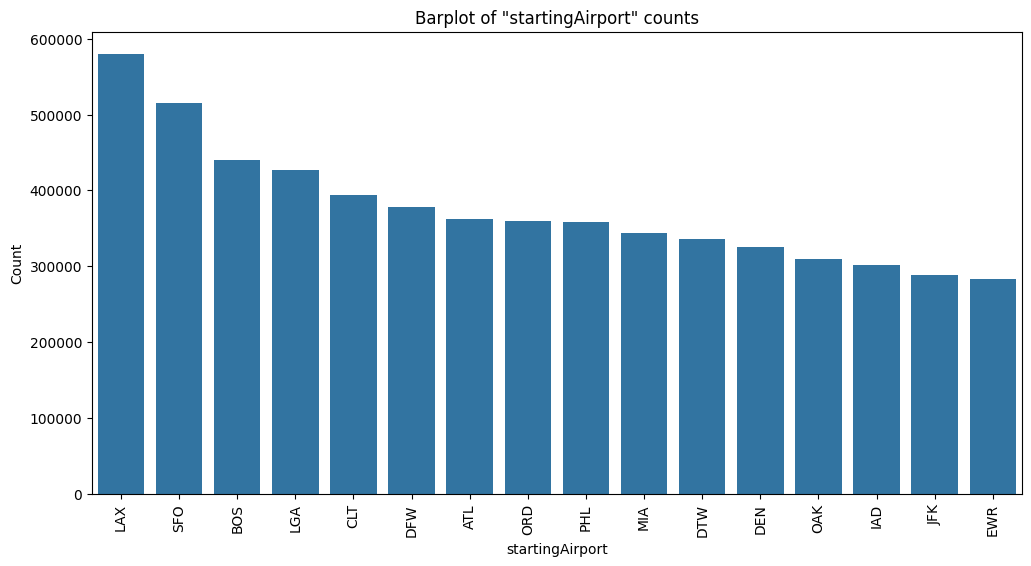

In [100]:
plot_cat_distribution(data=df, column_name="startingAirport")

Исходя из представленных расчетов, в дата-сете всего 16 аэропортов, откуда вылетали самолёты. Чаще всего вылетали из аэропорта LAX.

#### Анализ столбца `destinationAirport`

Проведем аналогичный анализ. Узнаем, куда чащего летают люди.

Первоначально узнаем, сколько нулевых значений присутствует в столбце `destinationAirport`

In [101]:
count_nulls(data=df, column_name="destinationAirport")

Число колонок с NULL: 0 (0.00%)


Поскольку снова пустых значений нету, то сразу перейдем к созданию функции расчета и визуализации распределения категориальных признаков.

Количество категорий признака destinationAirport: 16


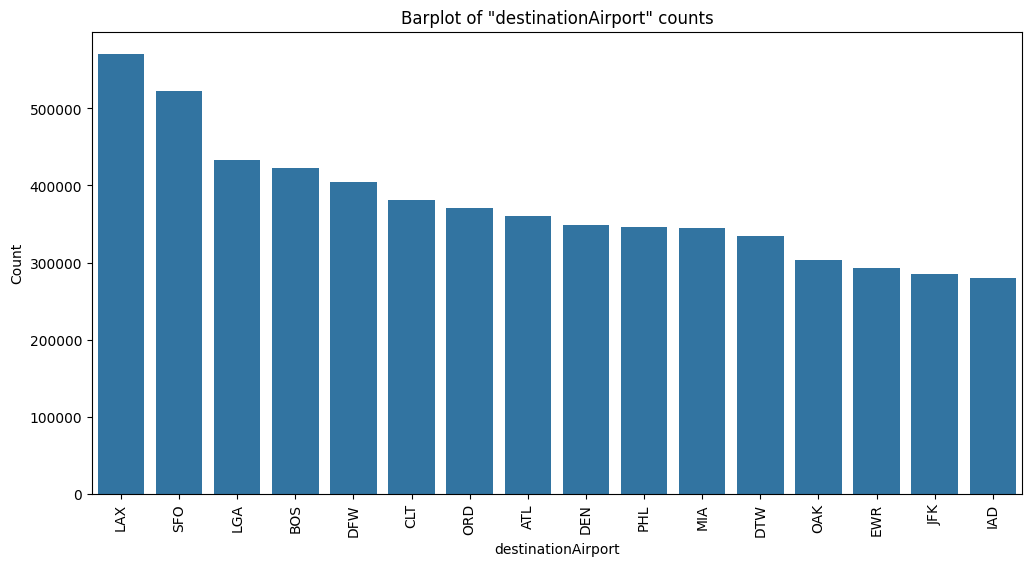

In [102]:
plot_cat_distribution(data=df, column_name="destinationAirport")

#### Анализ столбца `isRefundable`

Проверим столбец на пустые значения

In [103]:
count_nulls(data=df, column_name="isRefundable")

Число колонок с NULL: 0 (0.00%)


Построим график

Количество категорий признака isRefundable: 2


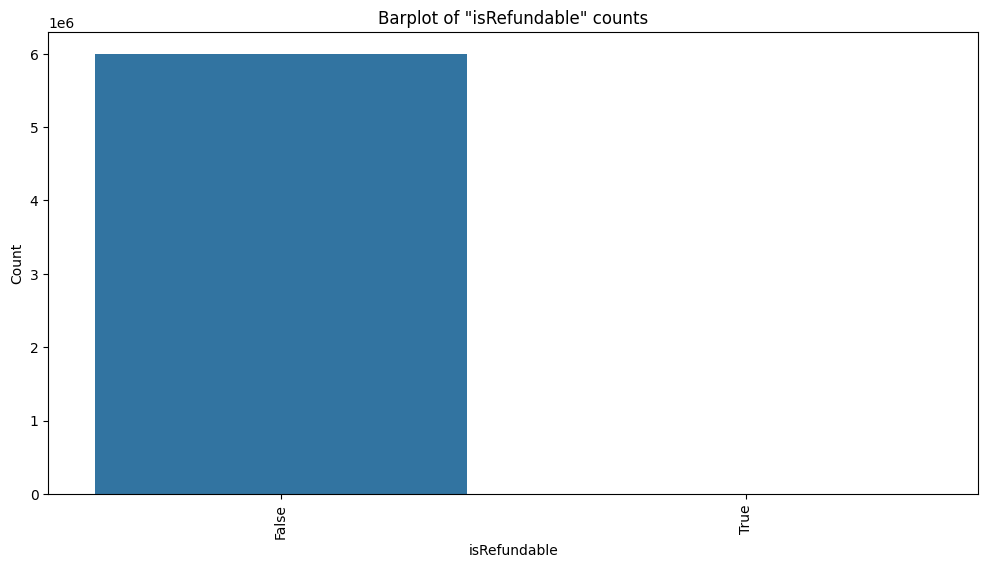

In [104]:
plot_cat_distribution(data=df, column_name="isRefundable")

Ни за один билет нельзя вернуть деньги

#### Анализ столбца `baseFare`, `totalFare`

Представим функцию, позволяющую рассчитывать статистические показатели данных в столбцах и строить диаграмму "ящик с усами" для оценки наличия выбросов.

In [105]:
def plot_boxplots(data: DataFrame,
                  columns: list[str],
                  sample_fraction: float = 0.1) -> None:
    """
    Построение boxplot для нескольких столбцов в PySpark DataFrame.

    Args:
        data (DataFrame): DataFrame, содержащий данные.
        columns (list of str): Список имен столбцов для построения boxplot.
        sample_fraction (float): Доля данных для семплирования выбросов.
    
    Returns:
        None
    """
    box_data = []

    for column in columns:
        # Вычисление квантилей
        quantiles = data.approxQuantile(column, [0.25, 0.5, 0.75], 0.01)
        q1, median, q3 = quantiles

        # Вычисление IQR и границ усов
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

        # Фильтрация выбросов
        filtered_df = data.filter((col(column) >= lower_bound) & (col(column) <= upper_bound))
        outliers_df = data.filter((col(column) < lower_bound) | (col(column) > upper_bound))

        # Вычисление минимального и максимального значений
        min_value = data.agg({column: "min"}).collect()[0][0]
        mean_value = data.agg({column: "mean"}).collect()[0][0]
        std_value = data.agg({column: "std"}).collect()[0][0]
        max_value = data.agg({column: "max"}).collect()[0][0]

        # Ограничение усов минимальным и максимальным значениями
        lower_bound = max(lower_bound, min_value)
        upper_bound = min(upper_bound, max_value)

        # Семплирование выбросов
        outliers = []
        if not outliers_df.isEmpty():
            sampled_outliers_df = outliers_df.sample(sample_fraction)
            outliers = (
                sampled_outliers_df
                .select(column)
                .limit(1000)
                .collect()
            )
            outliers = [row[column] for row in outliers]
            
            # Добавление минимального и максимального значений, если они 
            # относятся к выбросам и не присутствуют в семпле
            if min_value < lower_bound and min_value not in outliers:
                outliers.append(min_value)
            if max_value > upper_bound and max_value not in outliers:
                outliers.append(max_value)

        # Подготовка данных для axes.bxp
        box_data.append({
            'whislo': lower_bound,  # Нижняя граница усов
            'q1': q1,               # Первый квартиль
            'med': median,          # Медиана
            'q3': q3,               # Третий квартиль
            'whishi': upper_bound,  # Верхняя граница усов
            'fliers': outliers      # Выбросы
        })
        
    # Вывод статистических характеристик
    print(f"Минимальное значение:          {min_value:.2f}")
    print(f"Среднее значение:              {mean_value:.2f}")
    print(f"Среднеквадратичное отклонение: {std_value:.2f}")
    print(f"Первый квартиль:               {q1:.2f}")
    print(f"Медиана:                       {median:.2f}")
    print(f"Третий квартиль:               {q3:.2f}")
    print(f"Максимальное значение:         {max_value:.2f}")

    # Построение boxplot
    fig, ax = plt.subplots(figsize=(20, 6))
    ax.bxp(box_data, 
           vert=False, 
           positions=range(1, len(columns) + 1), widths=0.5)
    ax.set_yticks(range(1, len(columns) + 1))
    ax.set_yticklabels(columns)
    ax.set_xlabel('Value')
    ax.set_title('Boxplots')
    ax.grid(True)
    plt.show()

Минимальное значение:          0.01
Среднее значение:              359.13
Среднеквадратичное отклонение: 237.82
Первый квартиль:               202.79
Медиана:                       322.79
Третий квартиль:               460.47
Максимальное значение:         7662.33


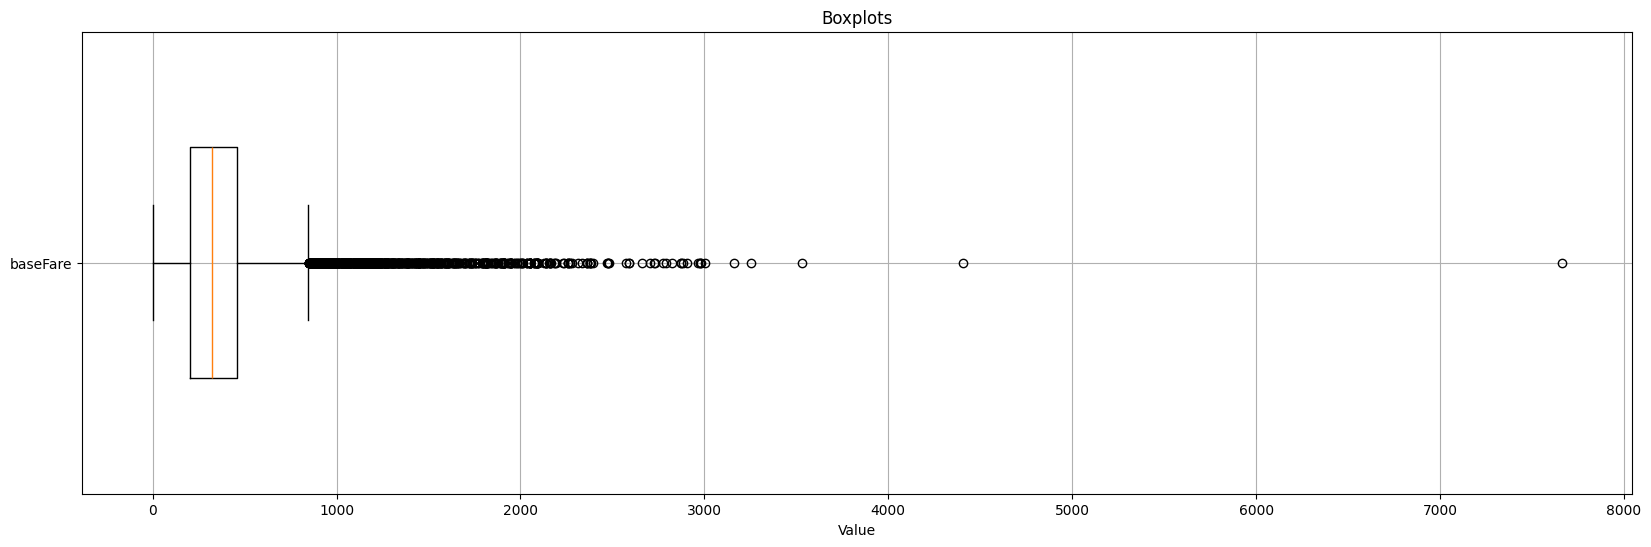

In [106]:
plot_boxplots(data=df, columns=["baseFare"])

Как видно из графика, наблюдается большое количество выбросов. Создадим функцию для визуального распределения категориального признака для более тщательного исследования.

In [107]:
def plot_quant_distribution(data: DataFrame,
                            column: str,
                            num_bins: int = 200) -> None:
    """
    Построение гистограммы для количественной переменной с 
    использованием PySpark и Seaborn.

    Args:
        data (DataFrame): DataFrame с данными.
        column_name (str): Название колонки с количественной переменной.
        num_bins (int): Количество бинов для гистограммы.

    Returns:
        None
    """
    # Находим минимальное и максимальное значения колонки
    min_value = data.agg({column: "min"}).collect()[0][0]
    max_value = data.agg({column: "max"}).collect()[0][0]

    # Размер бина
    bin_size = (max_value - min_value) / num_bins

    # Добавляем колонку с номером бина
    data = data.withColumn(
        "bin", 
        floor((col(column) - min_value) / bin_size)
    )

    # Группируем по номеру бина и считаем количество строк в каждом бине
    bin_counts = data.groupBy("bin").count()

    # Преобразуем результат в Pandas DataFrame для построения гистограммы
    bin_counts_pd = bin_counts.limit(1000).toPandas()
    
    # Создаем массив границ бинов
    bin_edges = [min_value + i * bin_size for i in range(num_bins + 2)]
    
    # Преобразуем номера бинов в центры бинов
    bin_centers = [
        (bin_edges[i] + bin_edges[i + 1]) / 2 for i in range(num_bins + 1)
    ]
    
    # Добавляем центры бинов в Pandas DataFrame
    bin_counts_pd['bin_center'] = bin_counts_pd['bin'].apply(
        lambda x: bin_centers[int(x)]
    )
    
    # Построение гистограммы с использованием Seaborn
    plt.figure(figsize=(20, 6))
    sns.histplot(data=bin_counts_pd, x="bin_center", 
                 weights="count", kde=True, bins=num_bins + 1)
    plt.xlabel("Value")
    plt.ylabel("Count")
    plt.title(f"Распределение количественного признака \"{column}\"")
    plt.grid(True)
    plt.show()

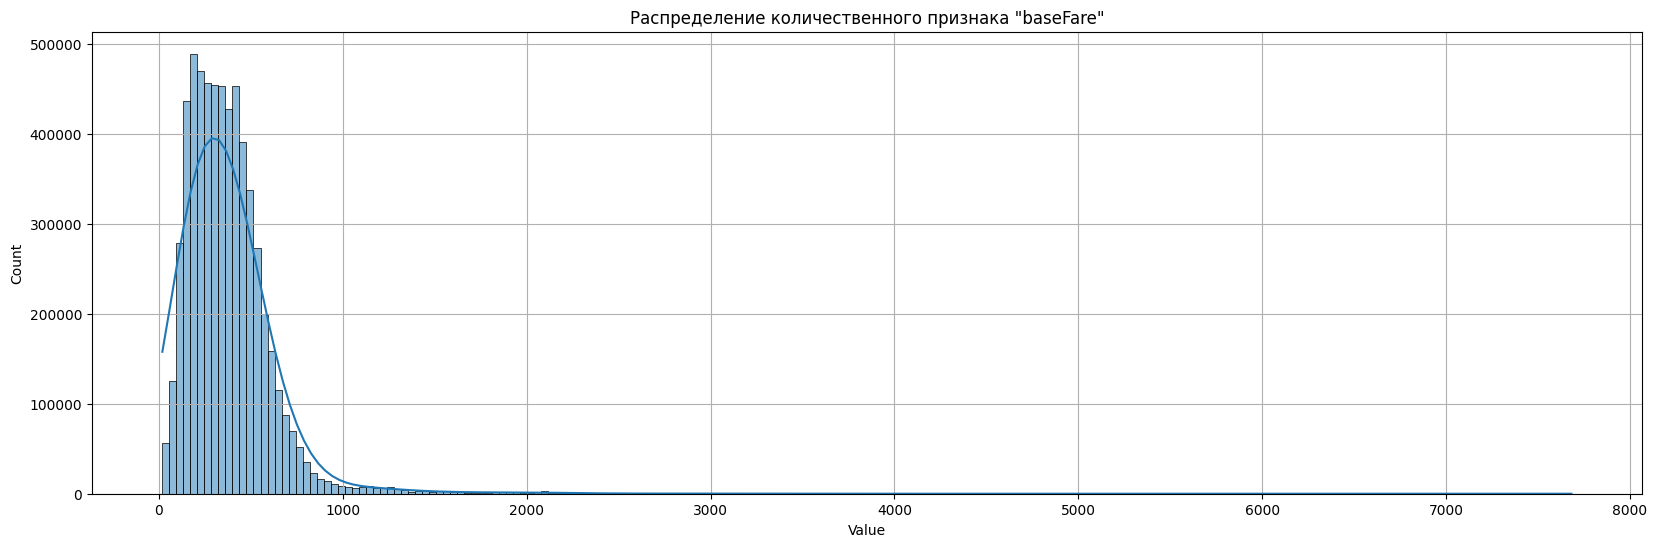

In [108]:
plot_quant_distribution(data=df, column="baseFare")

Установим, что данные не превышают 1500. Обрежем эти выбросы, установив границу в 1500.

In [109]:
df = df.withColumn(
    "baseFare",
    when(col("baseFare") > 1500.0, 1500.0)
        .otherwise(col("baseFare"))
)

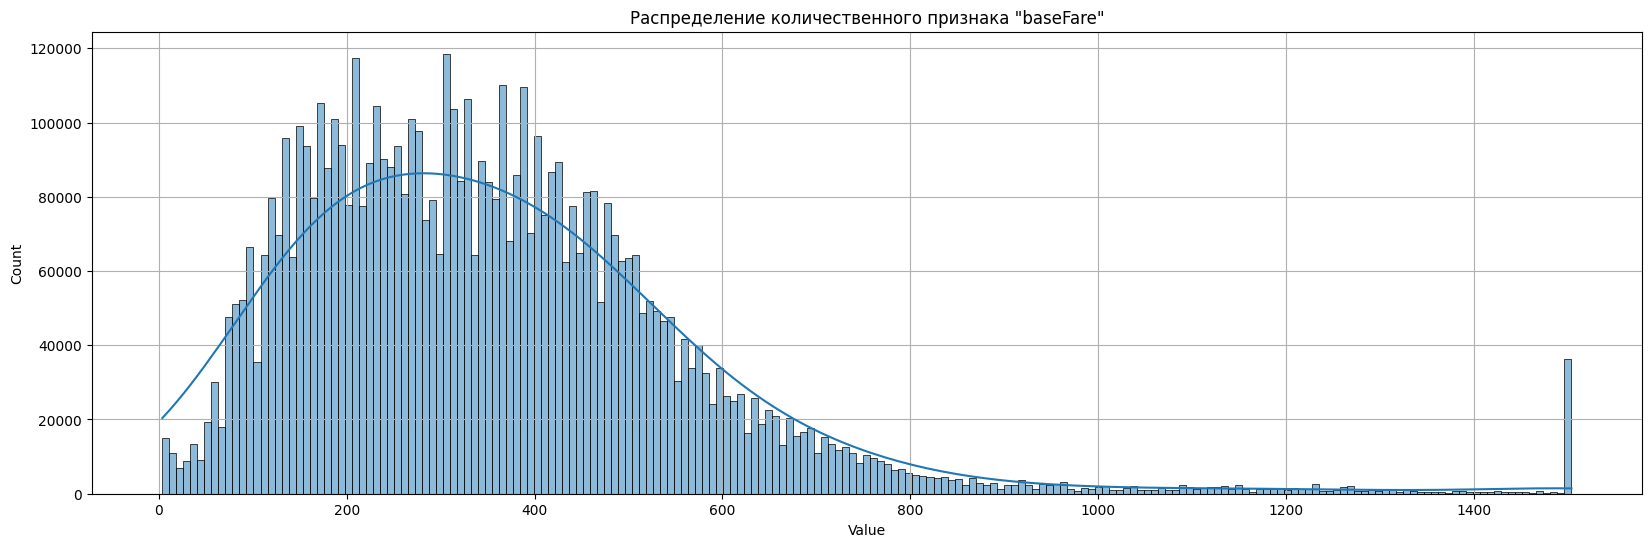

In [110]:
plot_quant_distribution(data=df, column="baseFare")

Проведем аналогичную работу для столбца `totalFare`

Минимальное значение:          19.59
Среднее значение:              412.63
Среднеквадратичное отклонение: 255.42
Первый квартиль:               242.60
Медиана:                       372.20
Третий квартиль:               518.61
Максимальное значение:         8260.61


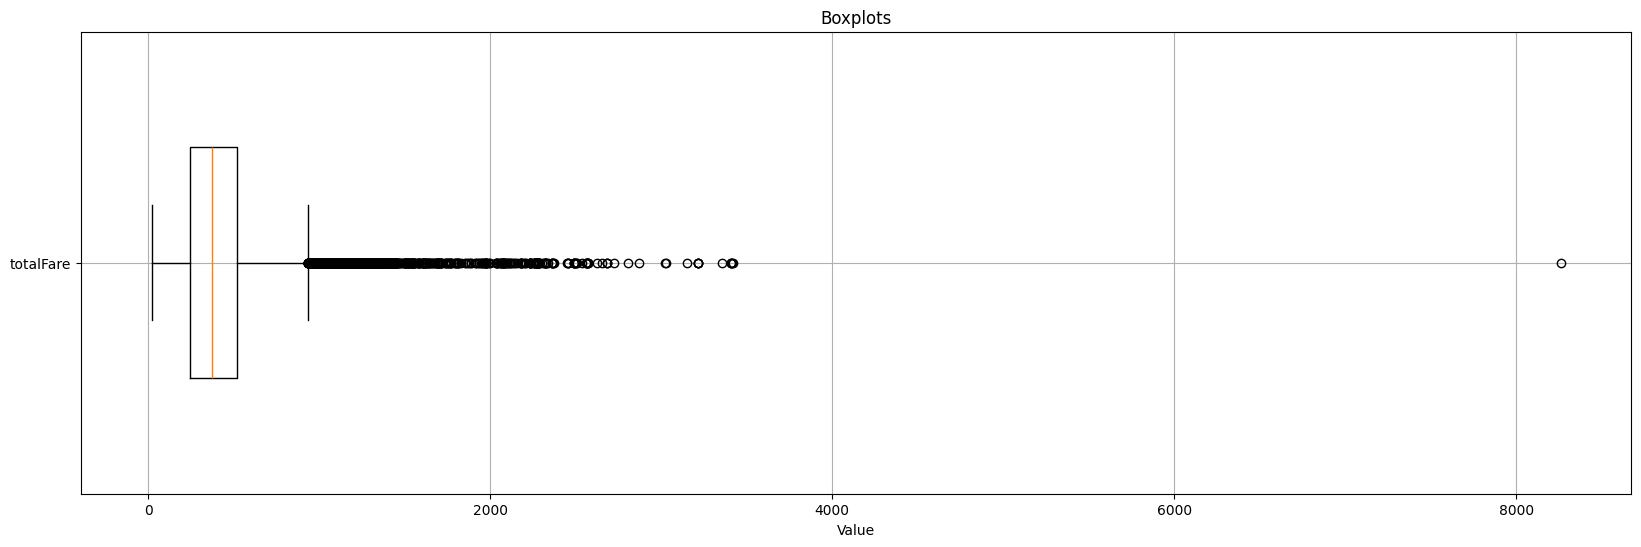

In [111]:
plot_boxplots(data=df, columns=["totalFare"])

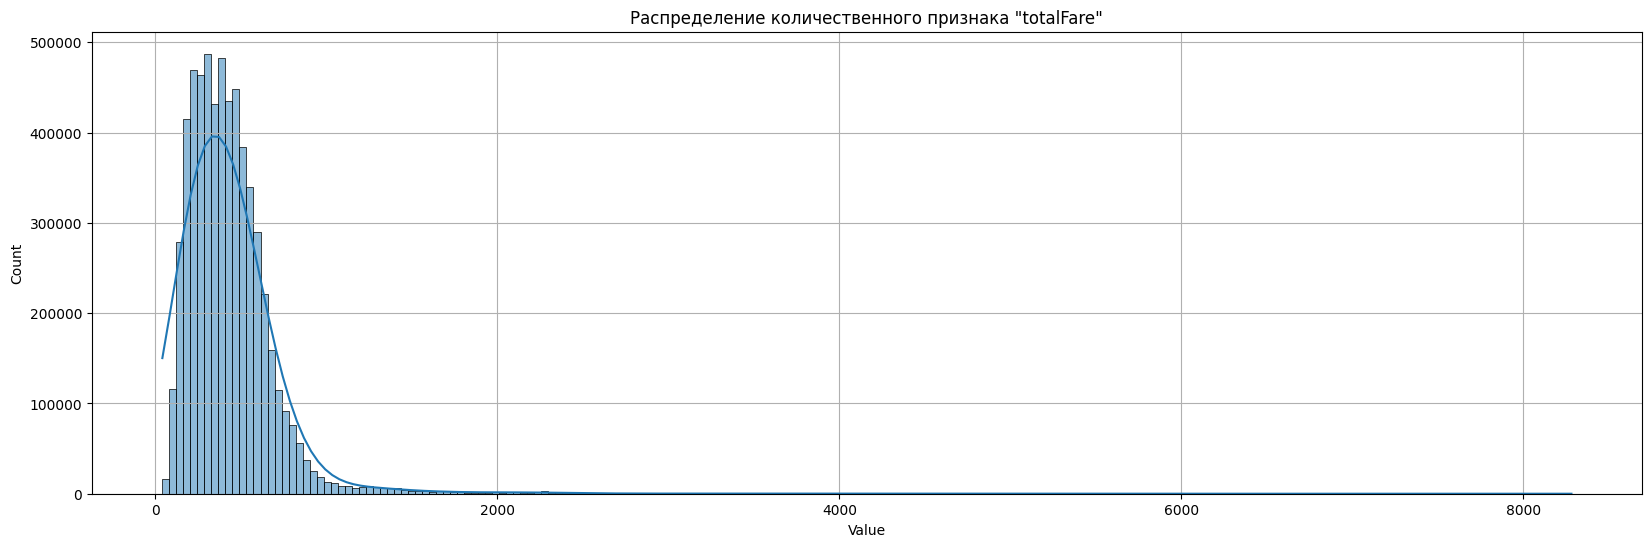

In [112]:
plot_quant_distribution(data=df, column="totalFare")

In [113]:
df = df.withColumn(
    "totalFare",
    when(col("totalFare") > 1750.0, 1750.0)
        .otherwise(col("totalFare"))
)

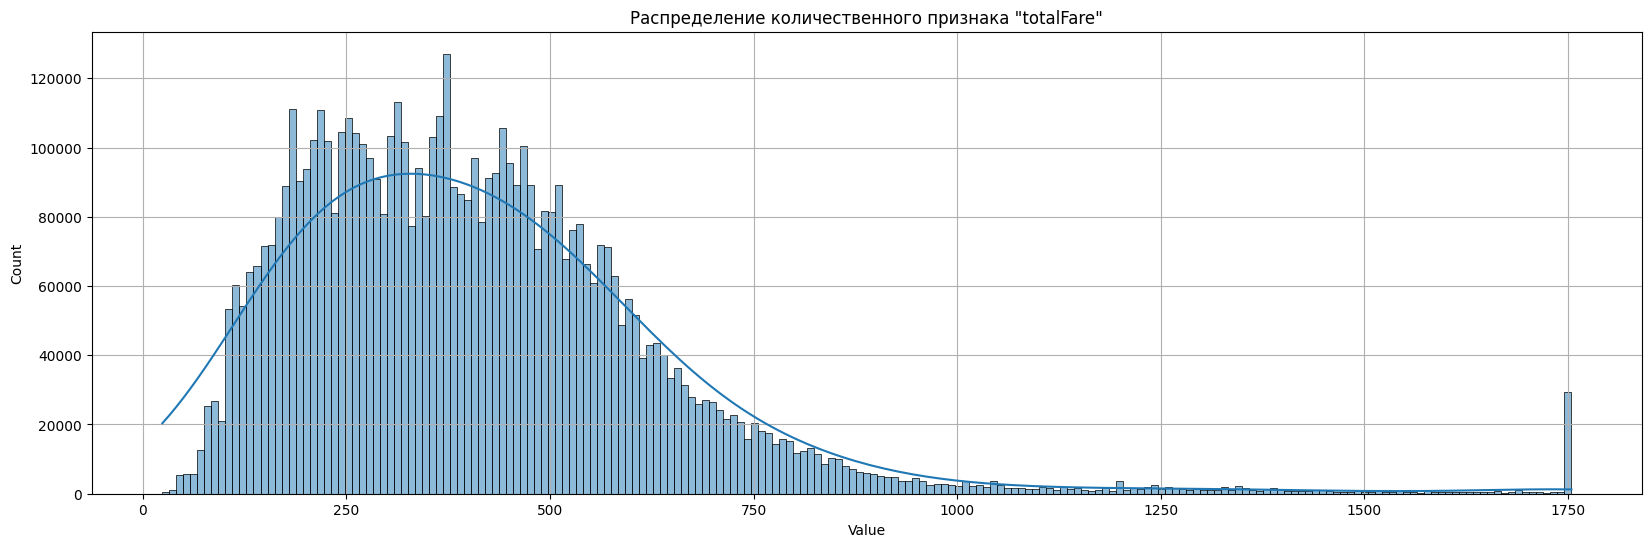

In [114]:
plot_quant_distribution(data=df, column="totalFare")

#### Анализ столбцов `segmentsDepartureTimeEpochSeconds`, `segmentsDurationInSeconds`

Введем функцию, определяющую количество NULL-значений в столбце.

In [115]:
count_nulls(data=df, column_name="segmentsDepartureTimeEpochSeconds")

Число колонок с NULL: 5348124 (89.14%)


In [116]:
df = df.drop("segmentsDepartureTimeEpochSeconds")

In [117]:
df.show()

+--------------------+---------------+------------------+------------+------------------+------------------+--------------------+----------------------------+-------------------------+----------------+-------------------+
|               legId|startingAirport|destinationAirport|isRefundable|          baseFare|         totalFare| segmentsAirlineName|segmentsEquipmentDescription|segmentsDurationInSeconds|segmentsDistance|  segmentsCabinCode|
+--------------------+---------------+------------------+------------+------------------+------------------+--------------------+----------------------------+-------------------------+----------------+-------------------+
|0000c808a6ac95ca4...|            MIA|               BOS|       false| 208.3699951171875|247.60000610351562|American Airlines...|        Boeing 737-800||B...|              12120||8340|       1192||862|       coach||coach|
|000859f937218c874...|            LAX|               BOS|       false| 274.4200134277344| 318.6000061035156|Amer

Проверим колонку `segmentsDurationInSeconds` на пустые значения

In [118]:
count_nulls(data=df, column_name="segmentsDurationInSeconds")

Число колонок с NULL: 0 (0.00%)


In [119]:
def parse_duration(duration_str):
    if '||' in duration_str:
        parts = duration_str.split('||')
        # Суммируем все части с использованием обычного цикла
        total_duration = 0
        for part in parts:
            total_duration += float(part)
    else:
        total_duration = float(duration_str)
    total_duration = total_duration / 60 / 60
    return total_duration

In [121]:
import pyspark.sql.functions as F
from pyspark.sql.types import FloatType  # Импортируем IntegerType

# Определяем UDF для функции parse_duration
parse_duration_udf = F.udf(parse_duration, FloatType())

# Создаем новую колонку totalDurationInSecond, применяя функцию parse_duration
df = df.withColumn("totalDurationInHour", parse_duration_udf(F.col("segmentsDurationInSeconds")))

df = df.drop("segmentsDurationInSeconds")

In [122]:
df.show()

+--------------------+---------------+------------------+------------+------------------+------------------+--------------------+----------------------------+----------------+-------------------+-------------------+
|               legId|startingAirport|destinationAirport|isRefundable|          baseFare|         totalFare| segmentsAirlineName|segmentsEquipmentDescription|segmentsDistance|  segmentsCabinCode|totalDurationInHour|
+--------------------+---------------+------------------+------------+------------------+------------------+--------------------+----------------------------+----------------+-------------------+-------------------+
|0000c808a6ac95ca4...|            MIA|               BOS|       false| 208.3699951171875|247.60000610351562|American Airlines...|        Boeing 737-800||B...|       1192||862|       coach||coach|          5.6833334|
|000859f937218c874...|            LAX|               BOS|       false| 274.4200134277344| 318.6000061035156|American Airlines...|       

Минимальное значение:          0.77
Среднее значение:              5.36
Среднеквадратичное отклонение: 1.85
Первый квартиль:               3.98
Медиана:                       5.23
Третий квартиль:               6.77
Максимальное значение:         16.42


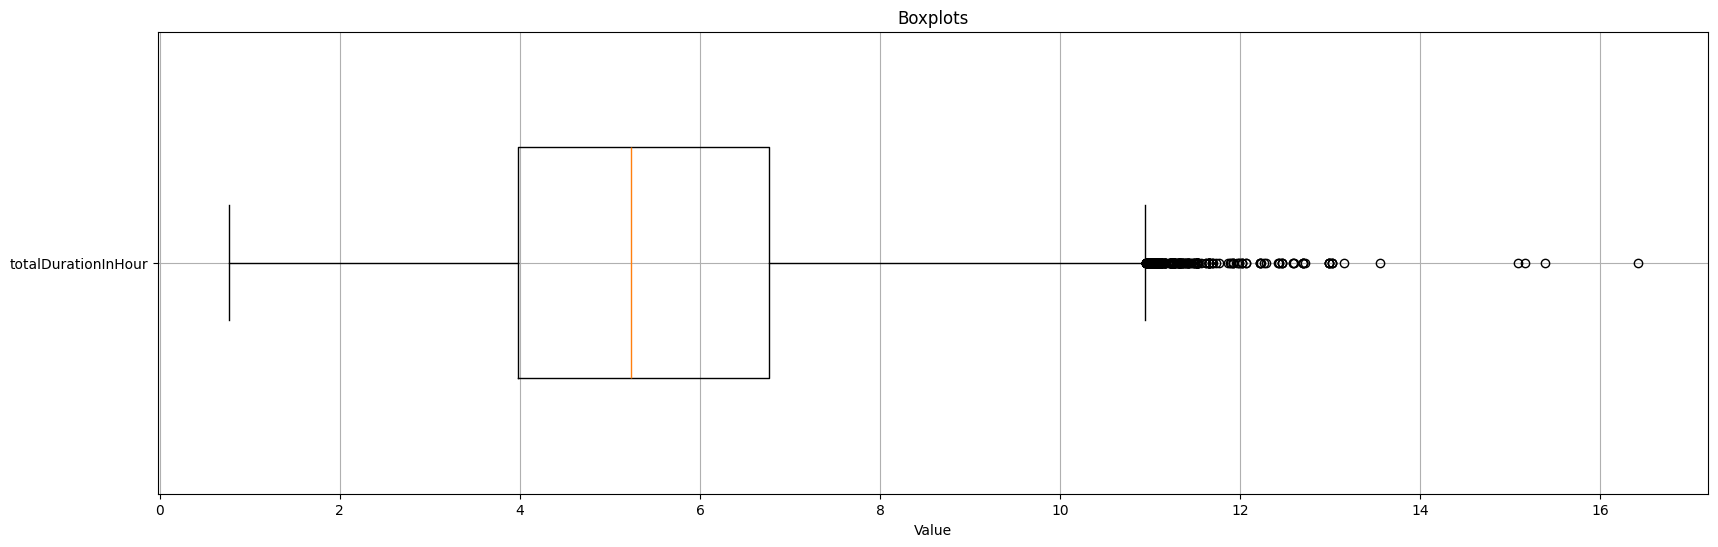

In [123]:
plot_boxplots(data=df, columns=["totalDurationInHour"])

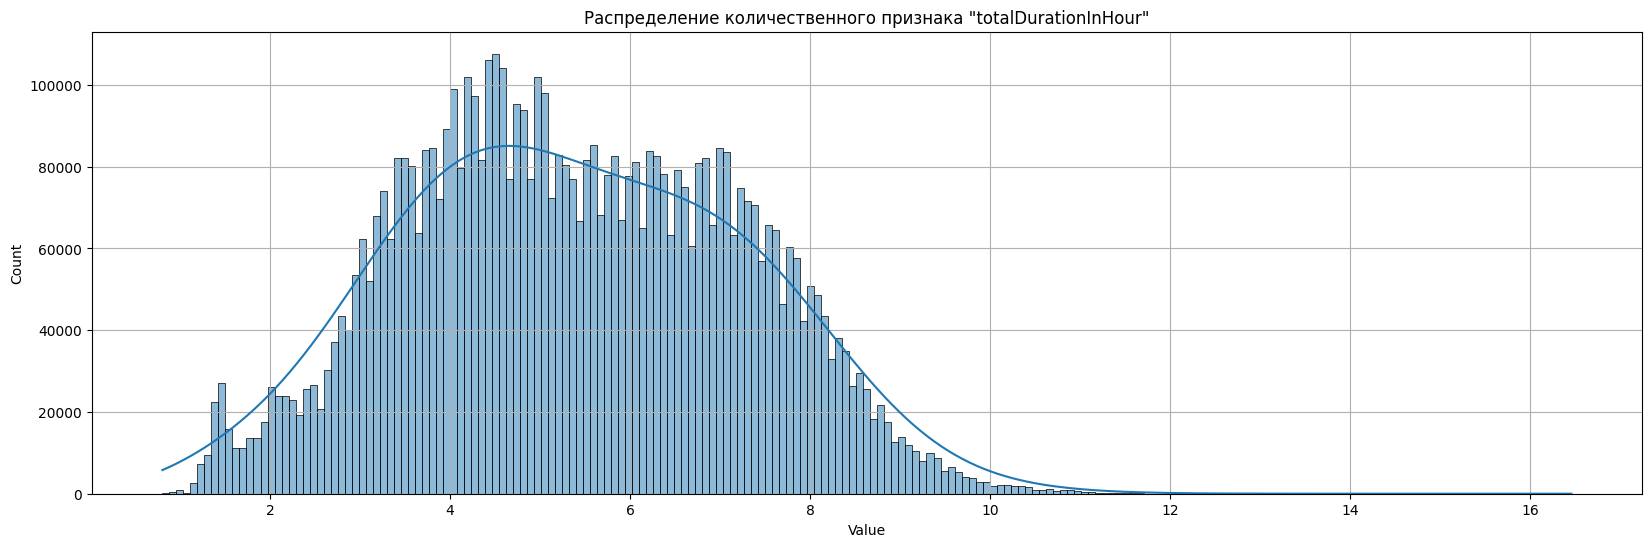

In [124]:
plot_quant_distribution(data=df, column="totalDurationInHour")

In [125]:
df = df.withColumn(
    "totalDurationInHour",
    when(col("totalDurationInHour") > 11.0, 11.0)
        .otherwise(col("totalDurationInHour"))
)

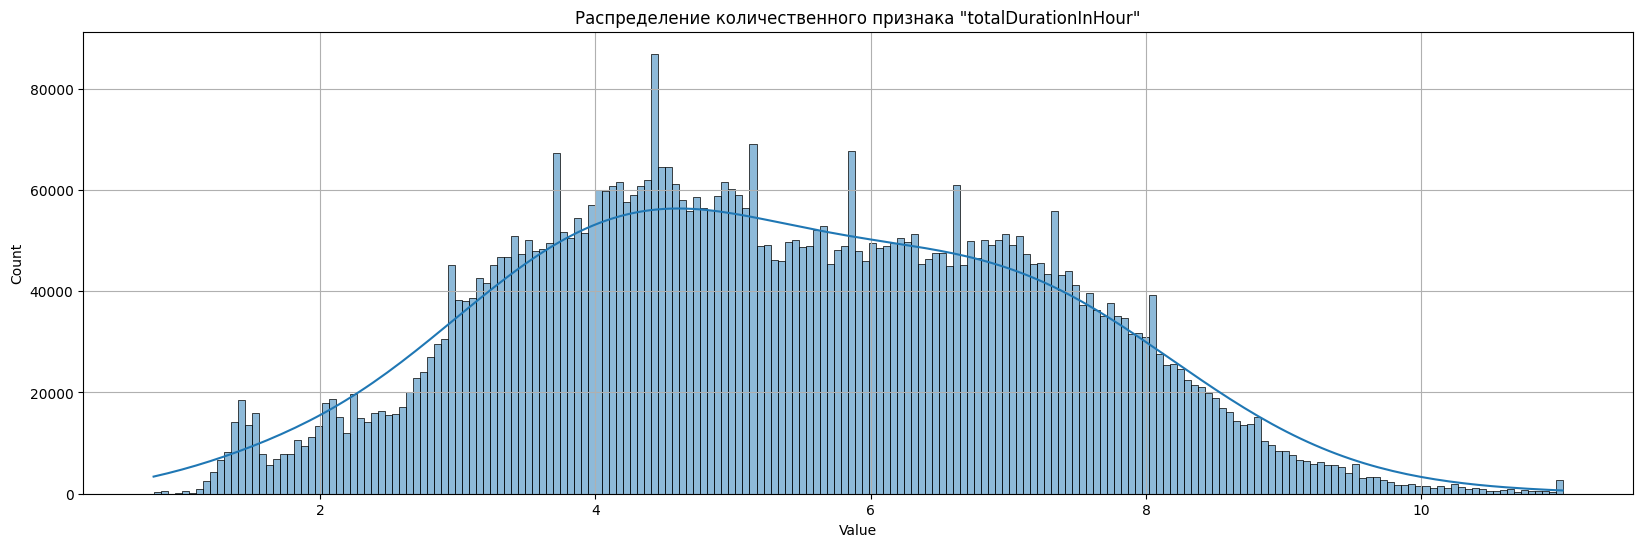

In [126]:
plot_quant_distribution(data=df, column="totalDurationInHour")

#### Анализ столбца `segmentsAirlineName`

In [127]:
count_nulls(data=df, column_name="segmentsAirlineName")

Число колонок с NULL: 0 (0.00%)


In [128]:
def split_names_and_replace_unknown(df: DataFrame, column_name: str) -> DataFrame:
    """
    Разделение строк в столбце по '||' и замена пустых значений на 'Unknown'.
    
    Args:
        df (DataFrame): DataFrame, содержащий данные.
        column_name (str): Имя столбца для обработки.
    
    Returns:
        DataFrame: Обновленный DataFrame с разделенными строками и заменой пустых значений на 'Unknown'.
    """
    # Условие 1: Проверяем, есть ли '||' и не является ли строка пустой после разделения
    df_split = df.withColumn(
        column_name, 
        F.when(
            (F.col(column_name).contains("||")) & (F.col(column_name) != "||"),
            F.split(F.col(column_name), '\|\|')
        ).otherwise(F.array(F.col(column_name)))
    )
    
    # Разворачиваем список значений (explode)
    df_exploded = df_split.withColumn(column_name, F.explode(F.col(column_name)))
    
    # Условие 2: Если строка была только '||', заменить на 'Unknown'
    df_cleaned = df_exploded.withColumn(
        column_name,
        F.when(F.trim(F.col(column_name)) == "", F.lit("Unknown")).otherwise(F.col(column_name))
    )
    
    return df_cleaned

In [129]:
# Вспомогательная функция для подготовки данных
def prepare_data_for_plot(df: DataFrame, column_name: str) -> DataFrame:
    """
    Подготовка данных для построения графика, включая разделение названий авиакомпаний.
    
    Args:
        df (DataFrame): Исходный DataFrame.
        column_name (str): Имя столбца с названиями авиакомпаний.
    
    Returns:
        DataFrame: Обновленный DataFrame с отдельными записями для каждой авиакомпании.
    """
    return split_names_and_replace_unknown(df, column_name)

Количество категорий признака segmentsAirlineName: 15


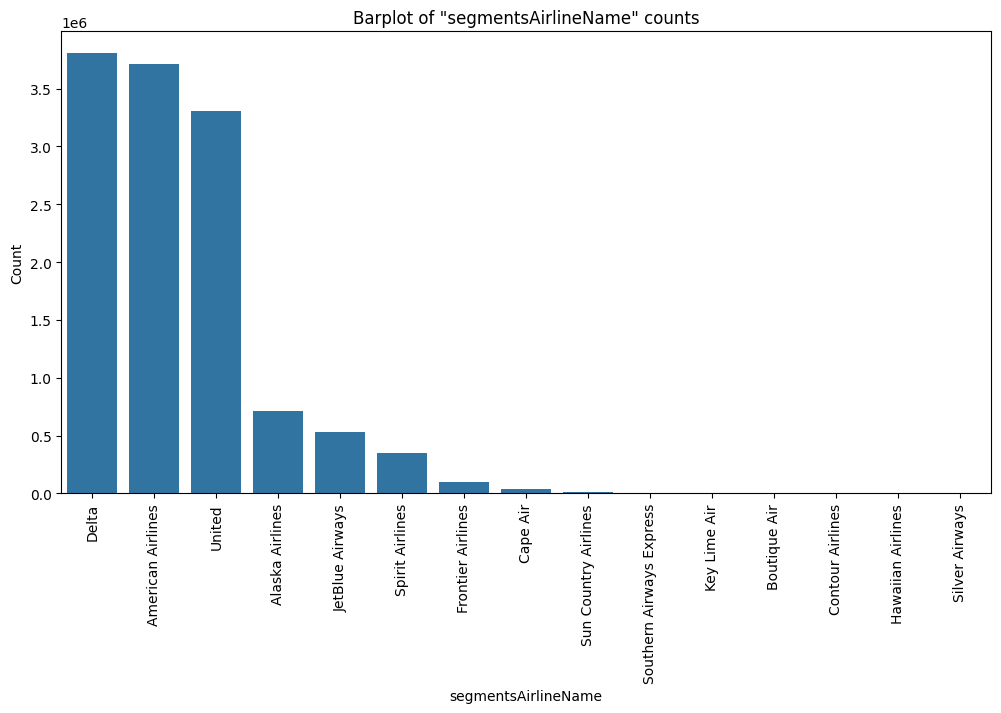

In [130]:
prepared_df = prepare_data_for_plot(df, column_name="segmentsAirlineName")
plot_cat_distribution(data=prepared_df, column_name="segmentsAirlineName")

#### Анализ столбца `segmentsEquipmentDescription`

In [131]:
count_nulls(data=df, column_name="segmentsEquipmentDescription")

Число колонок с NULL: 48538 (0.81%)


In [132]:
df = df.fillna({"segmentsEquipmentDescription": "||"})
count_nulls(data=df, column_name="segmentsEquipmentDescription")

Число колонок с NULL: 0 (0.00%)


Количество категорий признака segmentsEquipmentDescription: 49


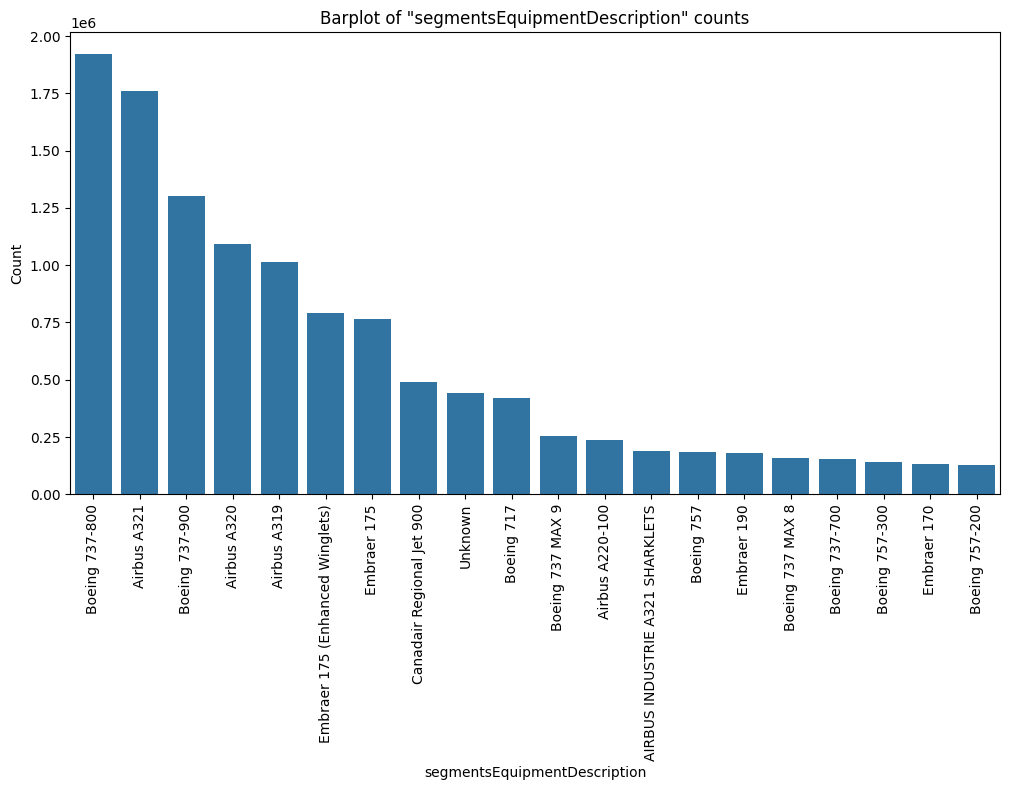

In [133]:
prepared_df = prepare_data_for_plot(df, column_name="segmentsEquipmentDescription")
plot_cat_distribution(data=prepared_df, column_name="segmentsEquipmentDescription")

#### Анализ столбца `segmentsDistance`

In [134]:
count_nulls(data=df, column_name="segmentsDistance")

Число колонок с NULL: 0 (0.00%)


In [135]:
df.filter(col('segmentsDistance') == "None").show()
df.filter(col('segmentsDistance') == "None||None").show()

+--------------------+---------------+------------------+------------+-----------------+------------------+-------------------+----------------------------+----------------+-----------------+-------------------+
|               legId|startingAirport|destinationAirport|isRefundable|         baseFare|         totalFare|segmentsAirlineName|segmentsEquipmentDescription|segmentsDistance|segmentsCabinCode|totalDurationInHour|
+--------------------+---------------+------------------+------------+-----------------+------------------+-------------------+----------------------------+----------------+-----------------+-------------------+
|02a25aa92aff8d18c...|            ORD|               LAX|       false|            162.0|218.58999633789062|    Spirit Airlines|        AIRBUS INDUSTRIE ...|            None|            coach|  4.349999904632568|
|039517ebdd984f810...|            LAX|               ORD|       false|            152.0|208.58999633789062|    Spirit Airlines|        AIRBUS INDUSTRIE 

+--------------------+---------------+------------------+------------+------------------+------------------+--------------------+----------------------------+----------------+-----------------+-------------------+
|               legId|startingAirport|destinationAirport|isRefundable|          baseFare|         totalFare| segmentsAirlineName|segmentsEquipmentDescription|segmentsDistance|segmentsCabinCode|totalDurationInHour|
+--------------------+---------------+------------------+------------+------------------+------------------+--------------------+----------------------------+----------------+-----------------+-------------------+
|0047bc2814177e8f0...|            ATL|               EWR|       false|              12.0| 57.58000183105469|Spirit Airlines||...|        AIRBUS INDUSTRIE ...|      None||None|     coach||coach|               4.75|
|005459f7777f54707...|            DTW|               DFW|       false|  659.530029296875| 732.5900268554688|        Delta||Delta|        Boeing 

In [136]:
df = df.filter(~(col('segmentsDistance').isin("None", "None||None", "None||None||None", "None||None||None||None")))
df.filter(col('segmentsDistance') == "None||None").show()
df.filter(col('segmentsDistance') == "None").show()

+-----+---------------+------------------+------------+--------+---------+-------------------+----------------------------+----------------+-----------------+-------------------+
|legId|startingAirport|destinationAirport|isRefundable|baseFare|totalFare|segmentsAirlineName|segmentsEquipmentDescription|segmentsDistance|segmentsCabinCode|totalDurationInHour|
+-----+---------------+------------------+------------+--------+---------+-------------------+----------------------------+----------------+-----------------+-------------------+
+-----+---------------+------------------+------------+--------+---------+-------------------+----------------------------+----------------+-----------------+-------------------+



+-----+---------------+------------------+------------+--------+---------+-------------------+----------------------------+----------------+-----------------+-------------------+
|legId|startingAirport|destinationAirport|isRefundable|baseFare|totalFare|segmentsAirlineName|segmentsEquipmentDescription|segmentsDistance|segmentsCabinCode|totalDurationInHour|
+-----+---------------+------------------+------------+--------+---------+-------------------+----------------------------+----------------+-----------------+-------------------+
+-----+---------------+------------------+------------+--------+---------+-------------------+----------------------------+----------------+-----------------+-------------------+



In [137]:
import pyspark.sql.functions as F
from pyspark.sql.types import DoubleType

def calculate_distance(distance_str):
    # Проверяем, есть ли '||' в строке
    if '||' in distance_str:
        # Разделяем строку и суммируем числа
        numbers = distance_str.split('||')
        total_distance = 0.0
        for num in numbers:
            num = num.strip()  # Удаляем лишние пробелы
            if num.isdigit():  # Проверяем, является ли строка числом
                total_distance += float(num)
        return total_distance if total_distance > 0 else None  # Возвращаем None, если сумма 0
    else:
        # Пробуем преобразовать строку в число, если нет '||'
        try:
            return float(distance_str)
        except ValueError:
            return None  # Если не удается преобразовать, возвращаем None

In [138]:
from pyspark.sql.types import FloatType

# Преобразуем вашу функцию в UDF для использования с PySpark
calculate_distance_udf = udf(calculate_distance, FloatType())
#  Применяем UDF к колонке с расстояниями
df = df.withColumn("calculatedDistance", calculate_distance_udf(F.col("segmentsDistance")))

In [139]:
count_nulls(data=df, column_name="calculatedDistance")

Число колонок с NULL: 0 (0.00%)


In [140]:
df.filter(col('calculatedDistance').isNull()).show()

+-----+---------------+------------------+------------+--------+---------+-------------------+----------------------------+----------------+-----------------+-------------------+------------------+
|legId|startingAirport|destinationAirport|isRefundable|baseFare|totalFare|segmentsAirlineName|segmentsEquipmentDescription|segmentsDistance|segmentsCabinCode|totalDurationInHour|calculatedDistance|
+-----+---------------+------------------+------------+--------+---------+-------------------+----------------------------+----------------+-----------------+-------------------+------------------+
+-----+---------------+------------------+------------+--------+---------+-------------------+----------------------------+----------------+-----------------+-------------------+------------------+



Минимальное значение:          89.00
Среднее значение:              1836.48
Среднеквадратичное отклонение: 840.51
Первый квартиль:               1132.00
Медиана:                       1763.00
Третий квартиль:               2567.00
Максимальное значение:         7252.00


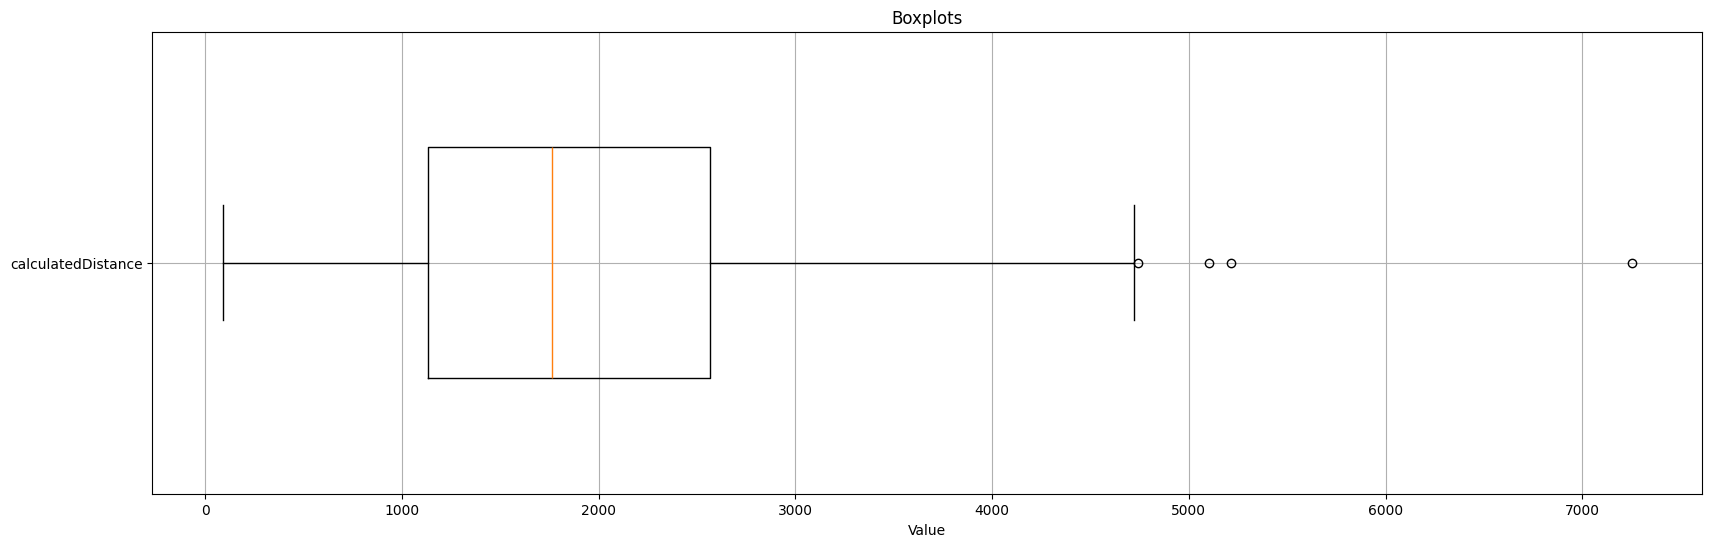

In [141]:
plot_boxplots(data=df, columns=["calculatedDistance"])

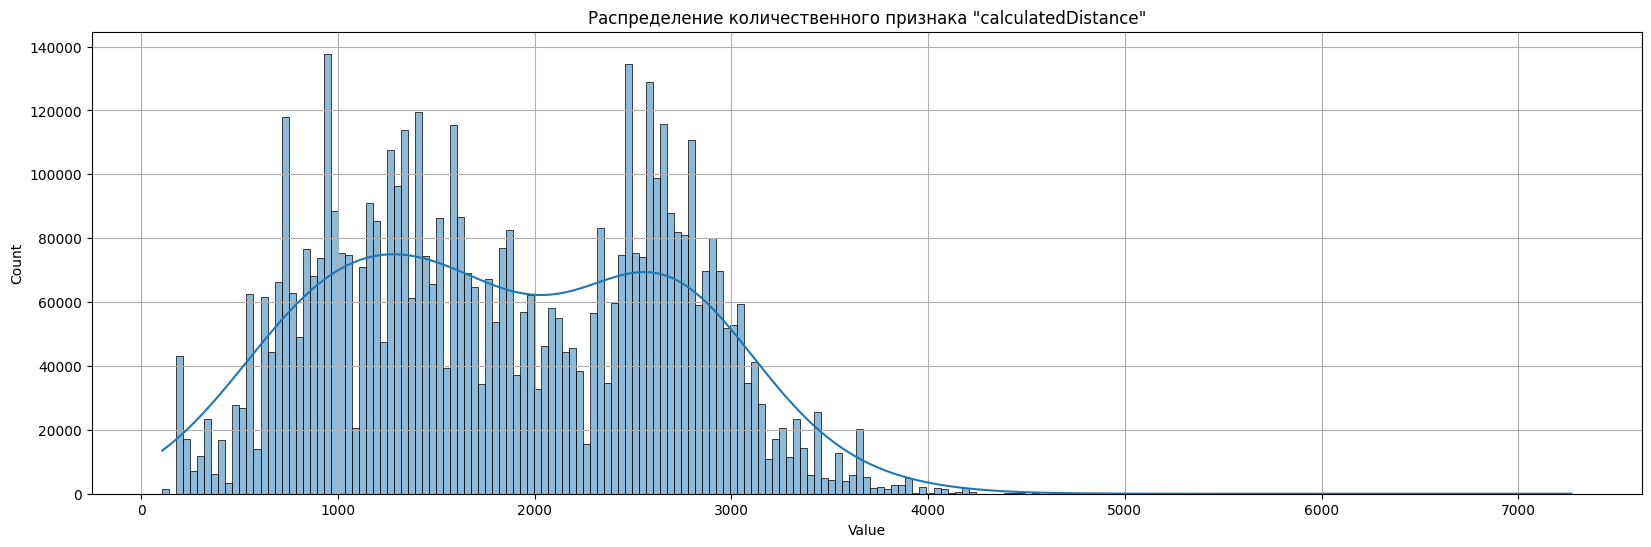

In [142]:
plot_quant_distribution(data=df, column="calculatedDistance")

In [143]:
# from pyspark.sql.functions import udf

# # 1. Преобразуем None в 'Unknown' в колонке distance_range
# df = df.withColumn("distance_range", F.when(F.col("calculatedDistance").isNull(), 'Unknown')
#                    .otherwise(F.when(F.col("calculatedDistance").between(0, 500), '0-500')
#                               .when(F.col("calculatedDistance").between(500, 1000), '500-1000')
#                               .when(F.col("calculatedDistance").between(1000, 2000), '1000-2000')
#                               .when(F.col("calculatedDistance").between(2000, 4000), '2000-4000')
#                               .otherwise('4000+')))

# # 2. Аггрегация данных: группируем по диапазонам расстояний и вычисляем среднюю цену
# price_distance = df.groupBy("distance_range").agg(F.mean("totalFare").alias("averageFare"))

# # 3. Преобразование в Pandas DataFrame для визуализации
# price_distance_pd = price_distance.toPandas()

# # 4. Убираем возможные строки с NaN в 'averageFare', если такие есть
# price_distance_pd = price_distance_pd.dropna(subset=["averageFare"])

# # 1. Создаем порядок категорий
# distance_order = ['0-500', '500-1000', '1000-2000', '2000-4000', '4000+', 'Unknown']

# # 2. Преобразуем колонку 'distance_range' в категориальный тип данных с определенным порядком
# price_distance_pd['distance_range'] = pd.Categorical(price_distance_pd['distance_range'], categories=distance_order, ordered=True)

# # 3. Сортируем значения по возрастанию расстояний
# price_distance_pd = price_distance_pd.sort_values('distance_range')

# # 4. Построение столбчатой диаграммы
# plt.figure(figsize=(10, 6))
# plt.bar(price_distance_pd['distance_range'], price_distance_pd['averageFare'], alpha=0.7)
# plt.title('Средняя цена в зависимости от расстояния')
# plt.xlabel('Расстояние (км)')
# plt.ylabel('Средняя цена (USD)')
# plt.xticks(rotation=90)
# plt.grid(axis='y')
# plt.show()

In [144]:
df = df.drop("distance_range")
df = df.drop("segmentsDistance")
df.show()

+--------------------+---------------+------------------+------------+------------------+------------------+--------------------+----------------------------+-------------------+-------------------+------------------+
|               legId|startingAirport|destinationAirport|isRefundable|          baseFare|         totalFare| segmentsAirlineName|segmentsEquipmentDescription|  segmentsCabinCode|totalDurationInHour|calculatedDistance|
+--------------------+---------------+------------------+------------+------------------+------------------+--------------------+----------------------------+-------------------+-------------------+------------------+
|0000c808a6ac95ca4...|            MIA|               BOS|       false| 208.3699951171875|247.60000610351562|American Airlines...|        Boeing 737-800||B...|       coach||coach|  5.683333396911621|            2054.0|
|000859f937218c874...|            LAX|               BOS|       false| 274.4200134277344| 318.6000061035156|American Airlines...

In [145]:
def compute_and_visualize_correlation_matrix(data: DataFrame, 
                                             columns: list[str]) -> None:
    """
    Вычисляет и визуализирует корреляционную матрицу для указанных 
    колонок в DataFrame PySpark.

    Args:
        df (DataFrame): DataFrame PySpark.
        columns (list[str]): Список колонок для вычисления корреляции.

    Returns:
        None
    """
    # Вычисление корреляционной матрицы
    corr_matrix = {}
    for col1 in columns:
        corr_matrix[col1] = {}
        for col2 in columns:
            corr_value = data.select(corr(col1, col2)).collect()[0][0]
            corr_matrix[col1][col2] = corr_value

    # Преобразование корреляционной матрицы в DataFrame Pandas для визуализации
    corr_matrix_pd = pd.DataFrame(corr_matrix)

    # Построение и визуализация корреляционной матрицы
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix_pd, annot=True, cmap='coolwarm', linewidths=0.5)
    plt.title('Correlation Matrix')
    plt.show()

In [146]:
df.printSchema()

root
 |-- legId: string (nullable = true)
 |-- startingAirport: string (nullable = true)
 |-- destinationAirport: string (nullable = true)
 |-- isRefundable: boolean (nullable = true)
 |-- baseFare: double (nullable = true)
 |-- totalFare: double (nullable = true)
 |-- segmentsAirlineName: string (nullable = true)
 |-- segmentsEquipmentDescription: string (nullable = false)
 |-- segmentsCabinCode: string (nullable = true)
 |-- totalDurationInHour: double (nullable = true)
 |-- calculatedDistance: float (nullable = true)



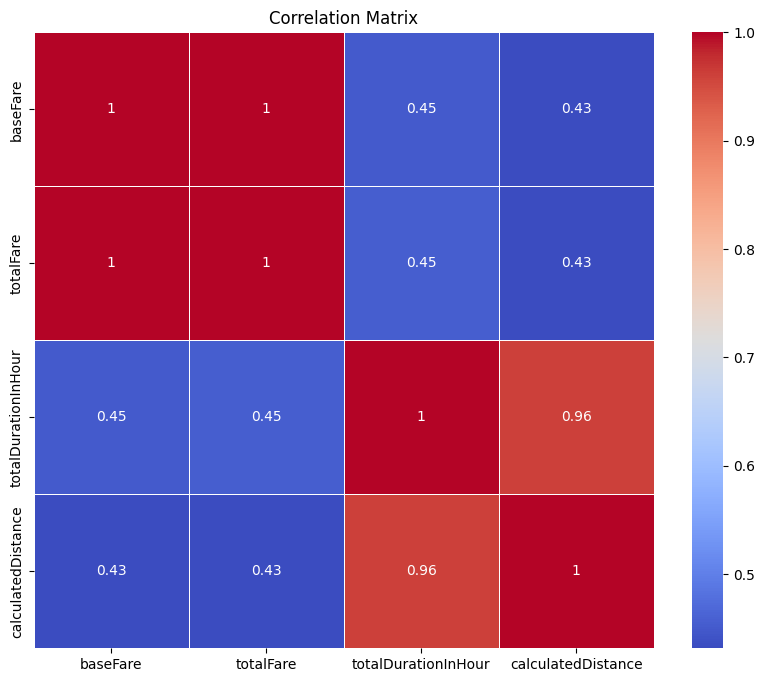

In [147]:
compute_and_visualize_correlation_matrix(
    data=df, columns=[
        "baseFare", "totalFare",
        "totalDurationInHour", "calculatedDistance"
    ]
)

#### Анализ столбца `segmentsCabinCode`

In [148]:
count_nulls(data=df, column_name="segmentsCabinCode")

Число колонок с NULL: 0 (0.00%)


Количество категорий признака segmentsCabinCode: 4


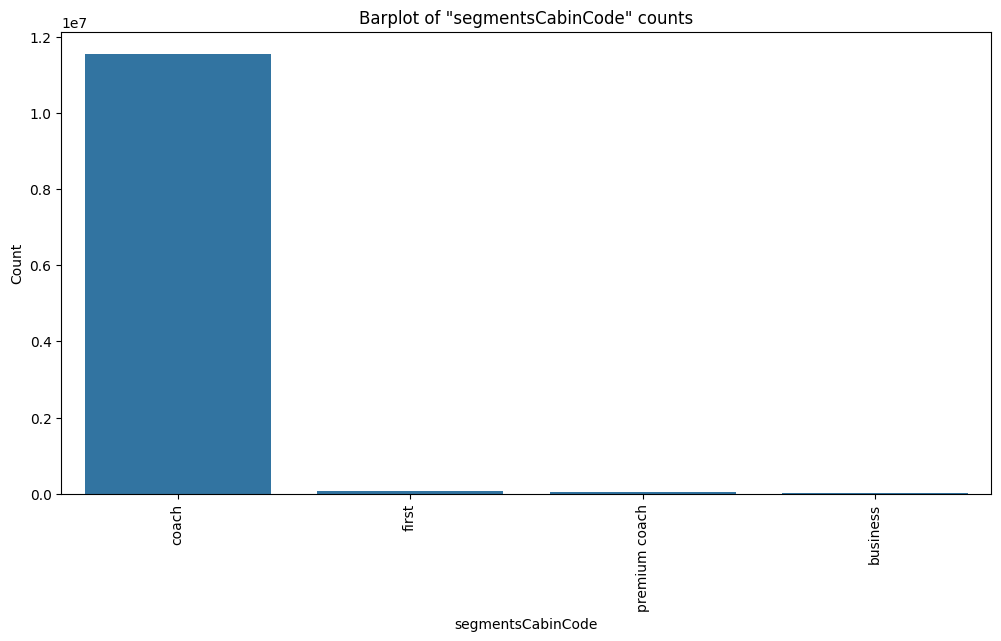

In [149]:
prepared_df = prepare_data_for_plot(df, column_name="segmentsCabinCode")
plot_cat_distribution(data=prepared_df, column_name="segmentsCabinCode")

In [150]:
# Подсчет количества для каждого класса обслуживания
class_distribution = prepared_df.groupBy('segmentsCabinCode').count().toPandas()

# Переименуем колонки для удобства
class_distribution.columns = ['serviceClass', 'count']

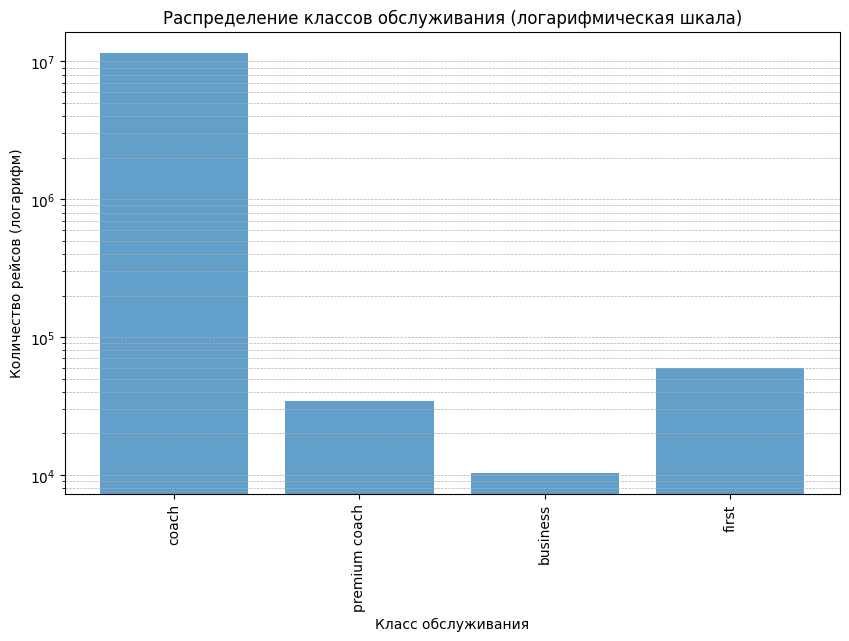

In [151]:
import matplotlib.pyplot as plt

# Построение графика с логарифмической шкалой по оси Y
plt.figure(figsize=(10, 6))
plt.bar(class_distribution['serviceClass'], class_distribution['count'], alpha=0.7)
plt.yscale('log')  # Логарифмическая шкала по оси Y
plt.title('Распределение классов обслуживания (логарифмическая шкала)')
plt.xlabel('Класс обслуживания')
plt.ylabel('Количество рейсов (логарифм)')
plt.xticks(rotation=90)
plt.grid(axis='y', which='both', linestyle='--', linewidth=0.5)
plt.show()

In [152]:
df.show()

+--------------------+---------------+------------------+------------+------------------+------------------+--------------------+----------------------------+-------------------+-------------------+------------------+
|               legId|startingAirport|destinationAirport|isRefundable|          baseFare|         totalFare| segmentsAirlineName|segmentsEquipmentDescription|  segmentsCabinCode|totalDurationInHour|calculatedDistance|
+--------------------+---------------+------------------+------------+------------------+------------------+--------------------+----------------------------+-------------------+-------------------+------------------+
|0000c808a6ac95ca4...|            MIA|               BOS|       false| 208.3699951171875|247.60000610351562|American Airlines...|        Boeing 737-800||B...|       coach||coach|  5.683333396911621|            2054.0|
|000859f937218c874...|            LAX|               BOS|       false| 274.4200134277344| 318.6000061035156|American Airlines...

In [153]:
df.count()

5536924

In [154]:
df.writeTo("sobd_lab1_processed_table").using("iceberg").create()

In [155]:
for table in spark.catalog.listTables():
    print(table.name)

sobd_lab1_table
sobd_lab1_processed_table


In [156]:
spark.stop()